# FIT5202 Data processing for big data Assignment 2

##  Rain in Australia: Predict rain tomorrow in Australia 

Predicting rain or weather is a common problem in machine learning. Different machine                           learning algorithms can be used to model and predict rainfall. In this assignment, we ask                               you to complete the analysis to predict whether there will be rain tomorrow or not. In                                 particular, you are required to apply the tools of machine learning to visualize and                             predict the possibility of rainfall in Australia.   

Required Datasets (available in Moodle):   
- Rain in Australia (​weatherAUS.csv​)     

The dataset is originally from Kaggle Dataset and can be found at ​this link​. It has been  modified to serve our purpose i.e. (to do the binary classification). 


In [1]:
# Import all the packages
from pyspark import SparkContext, SparkConf 
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from matplotlib import pyplot

##  A.Creating Spark Session and Loading the Data 

### Step 01: Import Spark Session and initialize Spark  
pyspark is the Spark Python API that exposes the Spark programming model to                           Python. You are already familiar with ​sparkContext from Assignment 1. ​sparkContext                       was used as a channel to access all spark functionality. In order to use APIs of SQL, HIVE,                                     and Streaming, separate contexts need to be created. From SPARK 2.0.0 onwards                         sparkSession provides a single point of entry to interact with underlying Spark                         functionality and allows programming Spark with Dataframe and Dataset APIs. All the                         functionality available with ​sparkContext​ are also available in ​sparkSession​.   

Write the code to create a sparkSession object, with 4 local cores. To create a                               sparkSession with 4 core you have to use configure it as ​local[4]. Give a name to your                                   program using ​appName().

In [2]:
# Create a spark context with 4 local cores.
sc = SparkContext.getOrCreate()
if (sc is None):
    sc = SparkContext(master="local[4]")

# Name the program with appName()
spark = SparkSession(sparkContext=sc)\
    .builder\
    .appName("Assignment 2")\
    .getOrCreate()

### Step 02: Load the dataset and print the schema and total number of entries
In ​sparkSession you can use ​spark_session.read.csv() method to load data as CSV                         format. You can download the dataset from Moodle. After you load the csv file into a                                 dataframe using spark session, write the code to print the total number of entries in the                                 dataset.  

In [3]:
# Read the data and save in a dataframe.
df = spark.read.csv("weatherAUS.csv", header = True, inferSchema = True)
total_lines = df.count()
print(("There are %d entries in the dataset."%total_lines))

There are 142193 entries in the dataset.


#### Answer
The total number of entries in the dataset is 142193.

##  B. Data Cleaning and Processing  
Data cleaning and processing is an important aspect for any machine learning task. We                             have to carefully look into the data and based on the types, quality of the data, we have                                     to plan our cleaning procedures.  


### Step 03: Delete columns from the dataset   
During the data cleaning and processing phase, we delete unnecessary data from                         the dataset to improve the efficiency and accuracy of our model. You have to think                               which columns are not contributing to the rain prediction. To keep things simple, you are                               required to delete the following columns due to data quality and accuracy. 
- Date  
- Location  
- Evaporation  
- Sunshine  
- Cloud9am  
- Cloud3pm  
- Temp9am  
- Temp3pm    

However, if you want to keep any of these columns, you can keep them if you process                                   them in an intelligent way that improve the accuracy, that is fine, ​however not                             mandatory​. 

In [4]:
# Delete irrelevant columns.
df = df.drop("Date","Location","Evaporation","Sunshine","Cloud9am","Cloud3pm","Temp9am","Temp3pm")

### Step 04: Print the number of missing data in each column
We already have an initial idea about the data structure from the schema. Even in                               plain eyes, we can observe that there are lots of NA (null) values in the given dataset.                                   Your job in this step is to print the number of NA(null) values in each column. 

In [5]:
# Create a udf to filter the NA values.
dropNa = udf(lambda x : not (x == "NA"), BooleanType())

# An empty list to save results.
null_count = []
null_count.append("Number of null values for each column:")

# Calculate number of NA values for each column.
for i in df.columns:
    null_count.append((i, total_lines - df.filter(dropNa(i)).count()))
    
# Print the result.
for i in null_count:
    print(i)

Number of null values for each column:
('MinTemp', 637)
('MaxTemp', 322)
('Rainfall', 1406)
('WindGustDir', 9330)
('WindGustSpeed', 9270)
('WindDir9am', 10013)
('WindDir3pm', 3778)
('WindSpeed9am', 1348)
('WindSpeed3pm', 2630)
('Humidity9am', 1774)
('Humidity3pm', 3610)
('Pressure9am', 14014)
('Pressure3pm', 13981)
('RainToday', 1406)
('RainTomorrow', 0)


### Step 05: Fill the missing data with average value and maximum occurrence value
In this step you have to fill in all the missing data with average value (for numeric                                   column) or maximum frequency value (for non-numeric column).  

Firstly, identify the columns which have numeric values (e.g., MinTemp, MaxTemp),                       calculate the average and fill the null value with the average.                              

Secondly, identify the columns with non-numeric values (e.g., WindGustDir, WindDir9am)                     and find the for frequent item (e.g., wind direction). Now fill the null values with that item                                   for that particular column.  

In [6]:
def calculateAvg(column):
    """Calculate the average value for a numeric column.
    
    :param column: the name of the given column
    :return: the average value
    :rtype: float
    """
    rdd = df.select(column).filter(dropNa(column)).rdd
    return round(rdd.map(lambda x : float(x[0]))\
                 .reduce(lambda x, y : x+ y)/rdd.count(),2)

def maxFrequency(column):
    """Find the max frquency item for a non-numeric column.
    
    :param column: the name of the given column
    :return: the max frquency item
    :rtype: String
    """
    rdd = df.select(column).filter(dropNa(column)).rdd
    text = rdd.map(lambda x : (x[0], 1))\
        .reduceByKey(lambda x,y : x + y)\
        .map(lambda x : (x[1], x[0]))\
        .sortByKey(ascending = False)\
        .collect()[0][1]
    return text

# Fill the NA values in each column
df = df.replace("NA",None)\
    .na.fill({"MinTemp": calculateAvg("MinTemp")})\
    .na.fill({"MaxTemp": calculateAvg("MaxTemp")})\
    .na.fill({"Rainfall": calculateAvg("Rainfall")})\
    .na.fill({"WindGustSpeed": calculateAvg("WindGustSpeed")})\
    .na.fill({"WindSpeed9am": calculateAvg("WindSpeed9am")})\
    .na.fill({"WindSpeed3pm": calculateAvg("WindSpeed3pm")})\
    .na.fill({"Humidity9am": calculateAvg("Humidity9am")})\
    .na.fill({"Humidity3pm": calculateAvg("Humidity3pm")})\
    .na.fill({"Pressure9am": calculateAvg("Pressure9am")})\
    .na.fill({"Pressure3pm": calculateAvg("Pressure3pm")})\
    .na.fill({"WindGustDir": maxFrequency("WindGustDir")})\
    .na.fill({"WindDir9am": maxFrequency("WindDir9am")})\
    .na.fill({"WindDir3pm": maxFrequency("WindDir3pm")})\
    .na.fill({"RainToday": maxFrequency("RainToday")})\
    .na.fill({"RainTomorrow": maxFrequency("RainTomorrow")})

### Step 06: Data transformation
In this step, you have to transform the data so that it will be useful to process by                                     the machine learning algorithm. Before transforming your non-numerical data, do the                       type casting (to double) of the numerical value columns as they are defined as “String”                               (see, the schema of the dataset). For the non-numerical value column (i.e., WindGustDir,                           WindDir9am, WindDir3pm, RainTomorrow) use the StringIndexer method to convert                   them into numbers.  

In [7]:
# Type casting to double
df = df.withColumn("MinTemp", df["MinTemp"].cast("double"))\
    .withColumn("MaxTemp", df["MaxTemp"].cast("double"))\
    .withColumn("Rainfall", df["Rainfall"].cast("double"))\
    .withColumn("WindGustSpeed", df["WindGustSpeed"].cast("double"))\
    .withColumn("WindSpeed9am", df["WindSpeed9am"].cast("double"))\
    .withColumn("WindSpeed3pm", df["WindSpeed3pm"].cast("double"))\
    .withColumn("Humidity9am", df["Humidity9am"].cast("double"))\
    .withColumn("Humidity3pm", df["Humidity3pm"].cast("double"))\
    .withColumn("Pressure9am", df["Pressure9am"].cast("double"))\
    .withColumn("Pressure3pm", df["Pressure3pm"].cast("double"))

# Convert Sting to numbers using StringIndexer
strCols = ["WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow"]
df_index = df

for i in strCols:
    indexer = StringIndexer(inputCol = i, outputCol = i + "Index")
    df_index = indexer.fit(df_index).transform(df_index)
    
df_index = df_index.drop("WindGustDir", "WindDir9am", "WindDir3pm", "RainToday", "RainTomorrow")

### Step 07: Create the feature vector and divide the dataset 
In this step, you have to create the feature vector from the given columns. When                               you create you feature vector, remember to exclude the column that you will be using                               for testing the accuracy of your model.     

After creation of your feature vector, you have split your dataset into two (e.g., training                               and testing). In this assignment, you have to spit the dataset randomly and between 70                               percent and 30 percent.  

In [8]:
# Transform all features into a vector
assembler = VectorAssembler(
    inputCols = df_index.columns[:14], 
    outputCol = "Features")
df_vector = assembler.transform(df_index).select("RainTomorrowIndex", "Features")

# Split the dataset randomly
(train, test) = df_vector.randomSplit([0.7, 0.3], 1)

## C. Apply Machine Learning Algorithms 
### Step 08: Apply machine learning classification algorithms on the dataset and                       compare their accuracy. Plot the accuracy as bar graph.
You have to use ​DecisionTreeClassifier(), RandomForestClassifier(), and               LogisticRegression(), GBTClassifier() methods in spark to calculate the probability of the                       rain fall tomorrow based on the other related data points (e.g., temperature, wind,                           humidity). Finally, you have to draw the graph (e.g. bar chart) to demonstrate the                             comparison of their accuracy.  

### Decision Tree

In [9]:
# Fit the model
dt = DecisionTreeClassifier(
    labelCol = "RainTomorrowIndex", 
    featuresCol = "Features")
dt_model = dt.fit(train)

# Predict
dt_prediction = dt_model.transform(test)

# Evaluate the accuracy
dt_evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrowIndex", 
    predictionCol="prediction", 
    metricName="accuracy")
dt_accuracy = dt_evaluator.evaluate(dt_prediction)

### Random Forest

In [10]:
# Fit the model
rf = RandomForestClassifier(
    labelCol = "RainTomorrowIndex", 
    featuresCol = "Features")
rf_model = rf.fit(train)

# Predict
rf_prediction = rf_model.transform(test)

# Evaluate the accuracy
rf_evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrowIndex", 
    predictionCol="prediction", 
    metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_prediction)

### Logistic Regresstion

In [11]:
# Fit the model
lr = LogisticRegression(
    labelCol = "RainTomorrowIndex", 
    featuresCol = "Features")
lr_model = lr.fit(train)

# Predict
lr_prediction = lr_model.transform(test)

# Evaluate the accuracy
lr_evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrowIndex", 
    predictionCol="prediction", 
    metricName="accuracy")
lr_accuracy = lr_evaluator.evaluate(lr_prediction)

### Gradient Boosted Trees(GBT)

In [12]:
# Fit the model
gbt = GBTClassifier(
    labelCol = "RainTomorrowIndex", 
    featuresCol = "Features")
gbt_model = gbt.fit(train)

# Predict
gbt_prediction = gbt_model.transform(test)

# Evaluate the accuracy
gbt_evaluator = MulticlassClassificationEvaluator(
    labelCol="RainTomorrowIndex", 
    predictionCol="prediction", 
    metricName="accuracy")
gbt_accuracy = gbt_evaluator.evaluate(gbt_prediction)

### Comparison

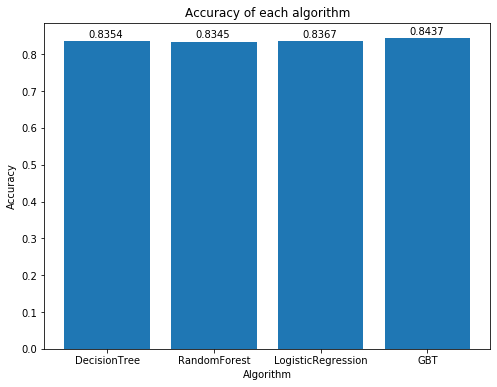

In [13]:
# Create x-axis and y-axis
x = ["DecisionTree", "RandomForest", "LogisticRegression", "GBT"]
y = [dt_accuracy, rf_accuracy, lr_accuracy, gbt_accuracy]

# Create a bar chart
fig, ax = pyplot.subplots() 
accuracy_bars = ax.bar(x, y)

# Add values on the top of bars
for bar in accuracy_bars:
    ax.text(bar.get_x() + bar.get_width()/3.5, bar.get_height() + 0.01, "%.4f"%bar.get_height())

# Set labels and size
ax.set_title('Accuracy of each algorithm')
ax.set_xlabel("Algorithm")
ax.set_ylabel("Accuracy")
fig.set_size_inches(8,6)

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1                           score of each classification algorithm. Explain how the accuracy of the                       predication can be improved?
Finding the accuracy of the model does not always represent the quality of the                             model for a given dataset. Number of false positive and false negative identification also                             plays an important role when we decide about any particular classification model. The                           way we can calculate is called confusion matrix. You can use confusionMatrix() method                           to calculate the confusion matrix. From the confusion matrix show the precision, recall                           and f1 score of each classification model. Explain how you can improve the accuracy of                               the predication.   

### Decision Tree

In [14]:
# Calculate the confusion matrix
dt_rdd = dt_prediction.select("prediction", "RainTomorrowIndex").rdd
dt_metrics = MulticlassMetrics(dt_rdd)
dt_cm = dt_metrics.confusionMatrix().toArray()

# Calculate the precision, recall and f1-score for "No" and "Yes".
dt_precision_0 = dt_metrics.precision(0)
dt_recall_0 = dt_metrics.recall(0)
dt_f1_0 = dt_metrics.fMeasure(0.0)
dt_precision_1 = dt_metrics.precision(1)
dt_recall_1 = dt_metrics.recall(1)
dt_f1_1 = dt_metrics.fMeasure(1.0)

# Print the result
print("Confusion Matrix:\n",dt_cm)
print("\nRain tomorrow?", "      No       ", "        Yes      ")
print("Precision: ", dt_precision_0, dt_precision_1)
print("Recall:    ", dt_recall_0, dt_recall_1)
print("F1 score:  ", dt_f1_0, dt_f1_1)

Confusion Matrix:
 [[31344.  1629.]
 [ 5362.  4143.]]

Rain tomorrow?       No                Yes      
Precision:  0.8539203399989103 0.7177754677754677
Recall:     0.9505959421344736 0.4358758548132562
F1 score:   0.8996684797428207 0.5423839759115009


Note: In this confusion matrix, the positive value represents "No rain", and the negative value represents "Rain tomorrow". The rows represents the prediction, and the columns represents real condition.

|Confusion Matrix|Condition Positive|Condition Negative|
|---|---|---|
|Prediction Positive|True Positive|False Positive|
|Prediction Negative|False Negative|True Negative|

### Random Forest

In [15]:
# Calculate the confusion matrix
rf_rdd = rf_prediction.select("prediction", "RainTomorrowIndex").rdd
rf_metrics = MulticlassMetrics(rf_rdd)
rf_cm = rf_metrics.confusionMatrix().toArray()

# Calculate the precision, recall and f1-score for "No" and "Yes".
rf_precision_0 = rf_metrics.precision(0)
rf_recall_0 = rf_metrics.recall(0)
rf_f1_0 = rf_metrics.fMeasure(0.0)
rf_precision_1 = rf_metrics.precision(1)
rf_recall_1 = rf_metrics.recall(1)
rf_f1_1 = rf_metrics.fMeasure(1.0)

# Print the result
print("Confusion Matrix:\n",rf_cm)
print("\nRain tomorrow?", "      No       ", "        Yes      ")
print("Precision: ", rf_precision_0, rf_precision_1)
print("Recall:    ", rf_recall_0, rf_recall_1)
print("F1 score:  ", rf_f1_0, rf_f1_1)

Confusion Matrix:
 [[31745.  1228.]
 [ 5800.  3705.]]

Rain tomorrow?       No                Yes      
Precision:  0.845518710880277 0.7510642610987229
Recall:     0.9627574075758955 0.38979484481851656
F1 score:   0.9003375024816359 0.5132289790829755


Note: In this confusion matrix, the positive value represents "No rain", and the negative value represents "Rain tomorrow". The rows represents the prediction, and the columns represents real condition.

|Confusion Matrix|Condition Positive|Condition Negative|
|---|---|---|
|Prediction Positive|True Positive|False Positive|
|Prediction Negative|False Negative|True Negative|

### Logistic Regresstion

In [16]:
# Calculate the confusion matrix
lr_rdd = lr_prediction.select("prediction", "RainTomorrowIndex").rdd
lr_metrics = MulticlassMetrics(lr_rdd)
lr_cm = lr_metrics.confusionMatrix().toArray()

# Calculate the precision, recall and f1-score for "No" and "Yes".
lr_precision_0 = lr_metrics.precision(0)
lr_recall_0 = lr_metrics.recall(0)
lr_f1_0 = lr_metrics.fMeasure(0.0)
lr_precision_1 = lr_metrics.precision(1)
lr_recall_1 = lr_metrics.recall(1)
lr_f1_1 = lr_metrics.fMeasure(1.0)

# Print the result
print("Confusion Matrix:\n",lr_cm)
print("\nRain tomorrow?", "      No       ", "        Yes      ")
print("Precision: ", lr_precision_0, lr_precision_1)
print("Recall:    ", lr_recall_0, lr_recall_1)
print("F1 score:  ", lr_f1_0, lr_f1_1)

Confusion Matrix:
 [[31258.  1715.]
 [ 5220.  4285.]]

Rain tomorrow?       No                Yes      
Precision:  0.8569000493448106 0.7141666666666666
Recall:     0.9479877475510265 0.4508153603366649
F1 score:   0.9001454262717599 0.5527249274427605


Note: In this confusion matrix, the positive value represents "No rain", and the negative value represents "Rain tomorrow". The rows represents the prediction, and the columns represents real condition.

|Confusion Matrix|Condition Positive|Condition Negative|
|---|---|---|
|Prediction Positive|True Positive|False Positive|
|Prediction Negative|False Negative|True Negative|

### Gradient Boosted Trees(GBT)

In [17]:
# Calculate the confusion matrix
gbt_rdd = gbt_prediction.select("prediction", "RainTomorrowIndex").rdd
gbt_metrics = MulticlassMetrics(gbt_rdd)
gbt_cm = gbt_metrics.confusionMatrix().toArray()

# Calculate the precision, recall and f1-score for "No" and "Yes".
gbt_precision_0 = gbt_metrics.precision(0)
gbt_recall_0 = gbt_metrics.recall(0)
gbt_f1_0 = gbt_metrics.fMeasure(0.0)
gbt_precision_1 = gbt_metrics.precision(1)
gbt_recall_1 = gbt_metrics.recall(1)
gbt_f1_1 = gbt_metrics.fMeasure(1.0)

# Print the result
print("Confusion Matrix:\n",gbt_cm)
print("\nRain tomorrow?", "      No       ", "        Yes      ")
print("Precision: ", gbt_precision_0, gbt_precision_1)
print("Recall:    ", gbt_recall_0, gbt_recall_1)
print("F1 score:  ", gbt_f1_0, gbt_f1_1)

Confusion Matrix:
 [[31244.  1729.]
 [ 4910.  4595.]]

Rain tomorrow?       No                Yes      
Precision:  0.8641920672677988 0.7265970904490828
Recall:     0.9475631577351166 0.48342977380326146
F1 score:   0.903959379113805 0.5805799481963484


Note: In this confusion matrix, the positive value represents "No rain", and the negative value represents "Rain tomorrow". The rows represents the prediction, and the columns represents real condition.

|Confusion Matrix|Condition Positive|Condition Negative|
|---|---|---|
|Prediction Positive|True Positive|False Positive|
|Prediction Negative|False Negative|True Negative|

### Improvement
In this case, there are some ways to improve the accuracy of the predication:

1. Using cross-validation for each algorithm. Divide the dataset into several parts. For each part, apply the algorithm and calculate the accuracy. At last, use the average accuracy as the model accuracy.

2. Deal with the outlier. The outlier can not reflect the real relation between features and prediction. The model will be more accurate without outliers.

3. Feature scaling. Standardize the range of features, to make sure different features have the same scale. Avoid the influence from different scale.

4. Obtain more training data. Large dataset can reduce the uncertainty of the prediction result, also increase stability of the model.